# Estructura del modelo

### Imports

In [1]:
import os
import librosa
import numpy as np
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Gestión del Dataset

### Funciones

In [2]:
def audio_to_spectrogram(file_path, sr = 11000, n_fft = 2048, hop_length = 512):
    # Cargar el audio
    y, sr = librosa.load(file_path, sr = sr)
    
    # Calcular el espectrograma (STFT)
    S = librosa.stft(y, n_fft = n_fft, hop_length = hop_length)
    
    # Convertir a magnitudes (la magnitud es el espectrograma)
    spectrogram = np.abs(S)
    
    # Escalar en logaritmo (opcional para mejor visualización y aprendizaje)
    log_spectrogram = librosa.amplitude_to_db(spectrogram, ref = np.max)

    return log_spectrogram

def spectrogram_to_audio_sin_fase(magnitud, sr, n_fft = 2048, hop_length = 512, n_iter = 32):
    # Hacemos la operación inversa de escalar el logaritmo
    spectrogram = librosa.db_to_amplitude(magnitud)

    # Reconstrucción del audio con Griffin-Lim
    audio_reconstruido = librosa.griffinlim(spectrogram, n_iter = n_iter, hop_length = hop_length, n_fft = n_fft)
    
    return audio_reconstruido

def visualize_spectrogram(spectrogram, title = "Spectrogram"):
    plt.figure(figsize=(10, 4))

    # Mostrar el espectrograma con un mapa de colores (viridis o inferno suelen ser útiles)
    plt.imshow(spectrogram, aspect = 'auto', origin = 'lower', cmap = 'viridis')
    plt.colorbar(label = "Decibels (dB)")
    plt.title(title)
    plt.xlabel("Time (frames)")
    plt.ylabel("Frequency (bins)")
    plt.tight_layout()
    
    plt.show()

def pad_or_trim(spectrogram, max_length = 20):
    if spectrogram.shape[1] > max_length:  # Recortar
        return spectrogram[:, :max_length]
    else:  # Rellenar
        padding = np.zeros((spectrogram.shape[0], max_length - spectrogram.shape[1]))
        return np.hstack((spectrogram, padding))
    
# Modificar el proceso de dataset
def load_dataset_with_padding(dataset_path, test_size=0.2, val_size=0.1):
    """
    Carga el dataset y asegura que todos los espectrogramas tengan la misma forma.
    """
    word_to_index = {}
    index_to_word = []
    spectrograms = []
    labels = []

    for idx, word in enumerate(os.listdir(dataset_path)):
        word_path = os.path.join(dataset_path, word)
        if not os.path.isdir(word_path):
            continue

        print(idx)
        word_to_index[word] = idx
        index_to_word.append(word)

        for index, audio_file in enumerate(os.listdir(word_path)):
            if index > 3000:
                break
            file_path = os.path.join(word_path, audio_file)

            try:
                spectrogram = audio_to_spectrogram(file_path)

                # Ajustar la forma del espectrograma
                spectrogram = pad_or_trim(spectrogram)

                spectrograms.append(spectrogram)
                labels.append(idx)
            except Exception as e:
                print(f"Error al procesar {file_path}: {e}")

    # Convertir a numpy arrays
    spectrograms = np.array(spectrograms)
    labels = np.array(labels)

    # Dividir en conjuntos de entrenamiento, validación y prueba
    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=test_size
    )

    return (X_train, y_train), (X_val, y_val), word_to_index, index_to_word

def create_tf_dataset(spectrograms, labels, batch_size=32):
    """
    Crea un dataset de TensorFlow a partir de los espectrogramas y las etiquetas.
    """
    # Convertir a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((labels, spectrograms))  # Usa etiquetas (texto) y espectrogramas
    dataset = dataset.shuffle(buffer_size=1000)  # Opcional: para aleatorizar
    dataset = dataset.batch(batch_size)  # Agrupar en lotes
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimiza el rendimiento

    return dataset


### Carga, clasificación y estructuración de los datos

In [3]:

path = "path"

# Supongamos que ya tienes los datos cargados como:
(X_train, y_train), (X_val, y_val), word_to_index, index_to_word = load_dataset_with_padding(path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


### Creación del Dataset

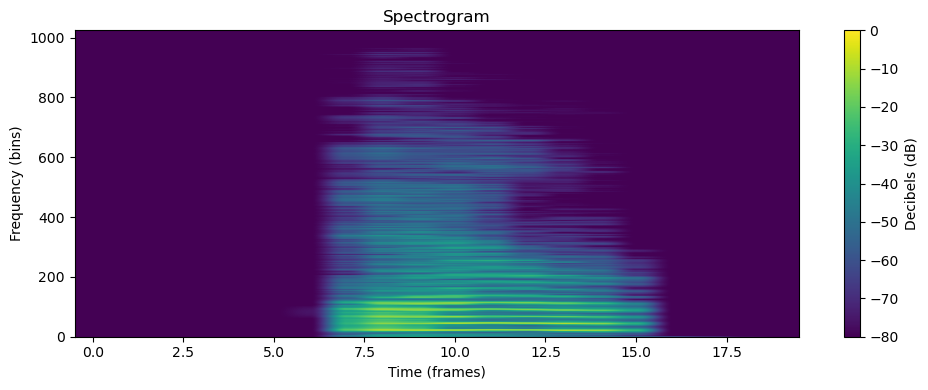

In [4]:
espectrograma = X_train[0]

visualize_spectrogram(espectrograma)

audio_original = spectrogram_to_audio_sin_fase(espectrograma, 11000)

sf.write("audio_original.wav", audio_original, samplerate = 11000, format = "wav")

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_val = X_val.astype('float32')
y_val = y_val.astype('float32')

# Crear los datasets de TensorFlow
train_dataset = create_tf_dataset(X_train, y_train)
val_dataset = create_tf_dataset(X_val, y_val)

# Modelo

### Estructura

In [5]:
class TextEncoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim):
        super(TextEncoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)

    def call(self, x):
        return self.embedding(x)

class SpectrogramDecoder(tf.keras.Model):
    def __init__(self, target_dim):
        super(SpectrogramDecoder, self).__init__()
        self.conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),  # Dropout para regularización
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # Padding para ajustar las dimensiones
            
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),

            tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.GlobalMaxPooling2D(),

            tf.keras.layers.Dense(target_dim, activation=None)  # No activación para espectrogramas sin normalizar
        ])

    def call(self, x):
        return self.conv(x)

class TextToSpectrogram(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, target_dim):
        super(TextToSpectrogram, self).__init__()
        self.encoder = TextEncoder(vocab_size, embed_dim)
        self.decoder = SpectrogramDecoder(target_dim)

    def call(self, x):
        x = self.encoder(x)
        return self.decoder(x)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



def create_transformer_model(vocab_size, embed_dim, num_heads, ff_dim, target_dim, max_length):
    # Crear las entradas
    input_text = tf.keras.layers.Input(shape=(1,), name="text_input")

    # Usar la clase TextToSpectrogram (TextEncoder + SpectrogramDecoder)
    text_to_spectrogram = TextToSpectrogram(vocab_size, embed_dim, target_dim)

    # Paso 1: Codificar el texto
    encoded_text = text_to_spectrogram.encoder(input_text)  # Salida del TextEncoder

    # Paso 2: Agregar un TransformerBlock entre el encoder y el decoder
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    transformed_text = transformer_block(encoded_text, training=True)  # Salida del bloque de transformador

    transformed_text = tf.expand_dims(transformed_text, -1)

    # Paso 3: Decodificar al espectrograma
    output_spectrogram_flat = text_to_spectrogram.decoder(transformed_text)  # Salida del decodificador

    # Cambiar la forma de la salida final
    output_spectrogram = tf.keras.layers.Reshape((1025, 20))(output_spectrogram_flat)  # Ajustar a la forma deseada

    # Crear el modelo
    model = tf.keras.Model(inputs=input_text, outputs=output_spectrogram, name="TextToSpectrogramTransformer")
    return model

# Entrenamiento del Modelo

### Funciones

In [6]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]  # Ajustar tamaño de las gráficas
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    # Pérdidas
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    ax1.legend(loc="upper right")

    # Métricas
    ax2.set_title('Mean Square Error (MSE)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE')
    ax2.grid()
    if 'mse' in history.history:
        ax2.plot(history.history['mse'], label='Training MSE', color='green')
    if 'val_mse' in history.history:
        ax2.plot(history.history['val_mse'], label='Validation MSE', color='red')
    ax2.legend(loc="upper right")

    # Mostrar las gráficas
    plt.show()


### Configuración

In [7]:
vocab_size = len(index_to_word) # Tamaño del vocabulario
embed_dim = 128
num_heads = 4
ff_dim = 128
target_dim = 1025 * 20
sample_rate = 11000
max_length = 500  # Ajusta según tus necesidades

model = create_transformer_model(vocab_size, embed_dim, num_heads, ff_dim, target_dim, max_length)
model.summary()


Model: "TextToSpectrogramTransformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, 1)]               0         
                                                                 
 text_encoder (TextEncoder)  (None, 1, 128)            3968      
                                                                 
 transformer_block (Transfor  (None, 1, 128)           297344    
 merBlock)                                                       
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 128, 1)        0         
                                                                 
 spectrogram_decoder (Spectr  (None, 20500)            67189332  
 ogramDecoder)                                                   
                                                                 
 reshape (Reshape)           (None, 10

### Compilación con Funciones de Pérdida

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mae",  # Error absoluto medio como métrica adicional
    metrics=["mse"]  # Error cuadrático medio
)

### Entrenamiento

In [9]:
epochs = 100
batch_size = 48

history = model.fit(train_dataset, validation_data=val_dataset, batch_size = batch_size, epochs = epochs)

Epoch 1/100
1365/1365 [==============================] - 64s 41ms/step - loss: 8.7772 - mse: 232.1239 - val_loss: 27.8821 - val_mse: 902.3129
Epoch 2/100
1365/1365 [==============================] - 55s 40ms/step - loss: 6.5606 - mse: 123.4753 - val_loss: 25.6120 - val_mse: 765.2694
Epoch 3/100
1365/1365 [==============================] - 56s 41ms/step - loss: 6.3771 - mse: 118.6400 - val_loss: 23.7585 - val_mse: 659.5991
Epoch 4/100
1365/1365 [==============================] - 54s 40ms/step - loss: 6.2530 - mse: 114.7886 - val_loss: 22.3526 - val_mse: 584.4197
Epoch 5/100
1365/1365 [==============================] - 55s 40ms/step - loss: 6.1594 - mse: 112.0200 - val_loss: 21.5471 - val_mse: 544.6432
Epoch 6/100
1365/1365 [==============================] - 56s 41ms/step - loss: 6.1076 - mse: 110.6686 - val_loss: 20.7809 - val_mse: 506.9751
Epoch 7/100
1365/1365 [==============================] - 55s 40ms/step - loss: 6.0713 - mse: 109.9011 - val_loss: 20.7667 - val_mse: 506.3238
Epoch 

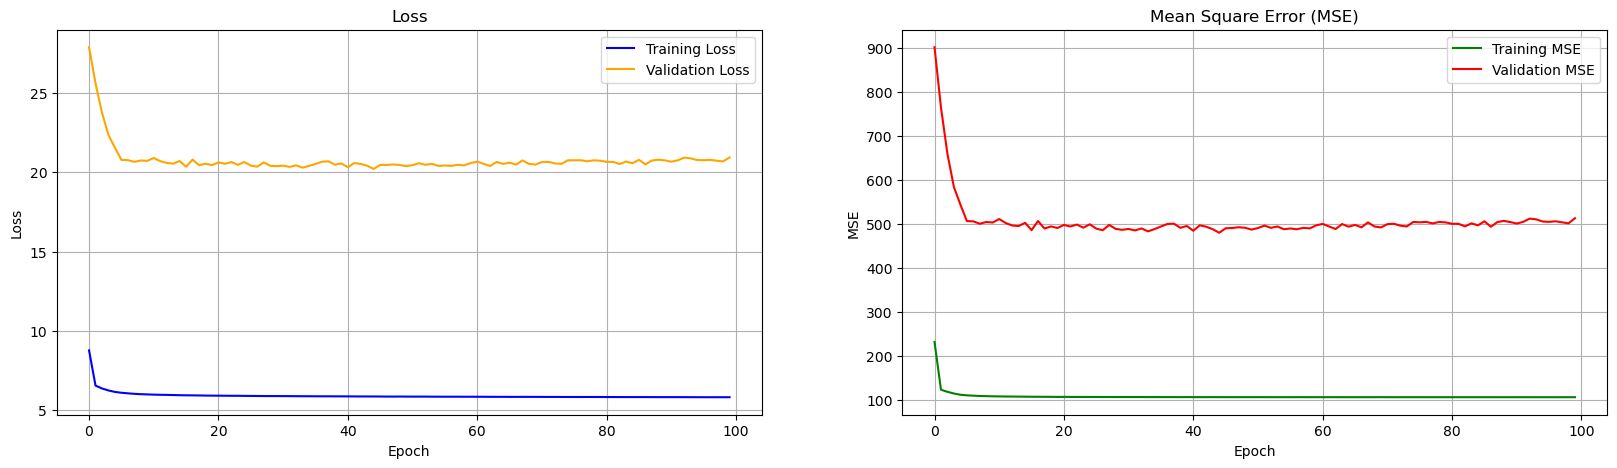

In [10]:
plot_losses(history)

# Obtención de los espectogramas

### Obtener la predicción

In [11]:
# Hacer la predicción
predicted_spectrogram = model.predict([4])

# Como 'predicted_spectrogram' tendrá la forma (1, 1025, 94), accedemos al primer elemento
spectrogram = predicted_spectrogram[0]  # El espectrograma de la palabra

1/1 [==============================] - 0s 484ms/step


### Visualizar el espectrograma predecido

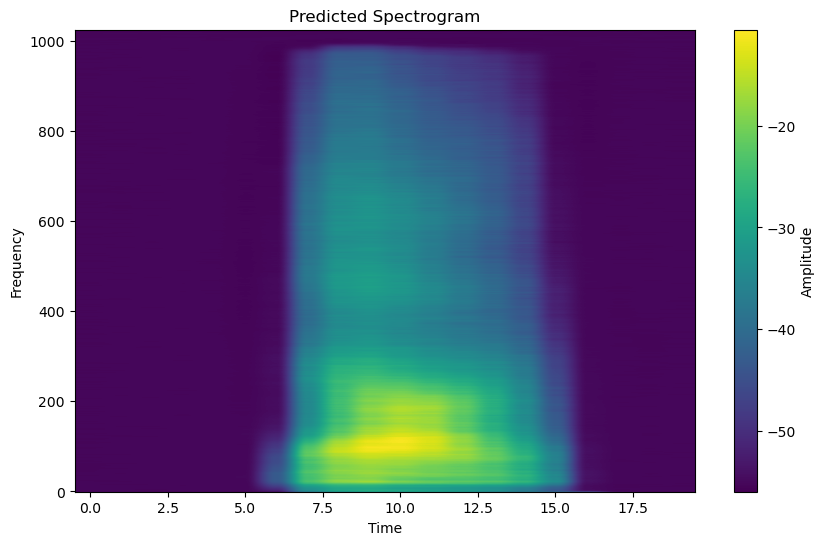

In [12]:
# Asume que el modelo devuelve un espectrograma con dimensiones (1025, 94)
spectrogram = predicted_spectrogram[0]  # Toma el primer resultado en el batch

# Visualiza el espectrograma
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title('Predicted Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

### Obtener Audio

1/1 [==============================] - 0s 31ms/step
backward


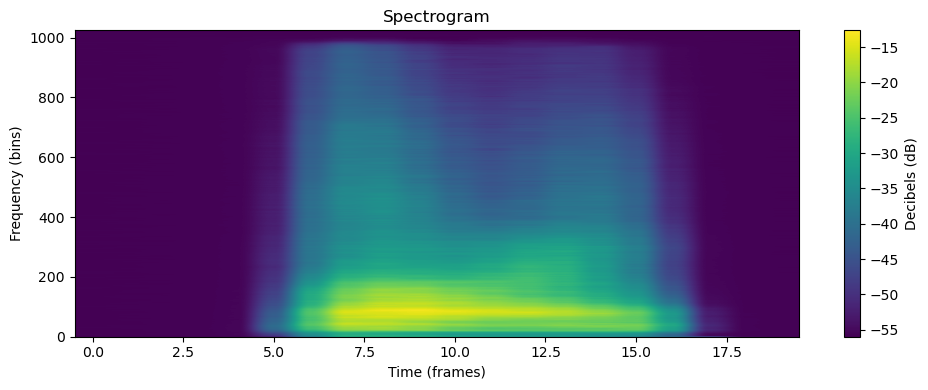

1/1 [==============================] - 0s 29ms/step
bed


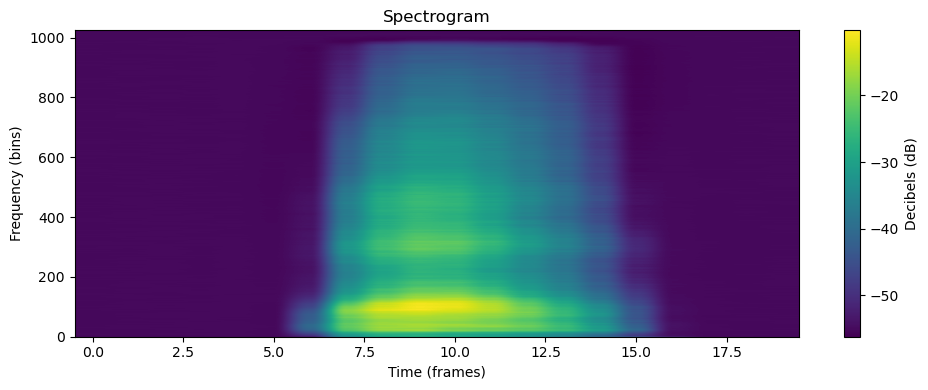

1/1 [==============================] - 0s 31ms/step
bird


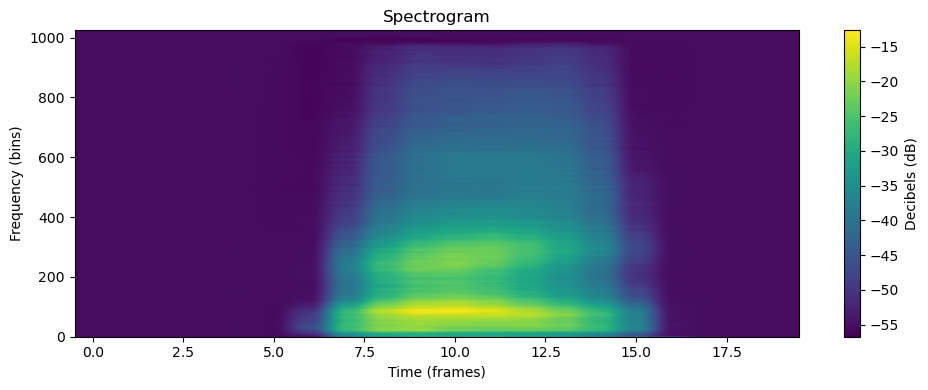

1/1 [==============================] - 0s 35ms/step
cat


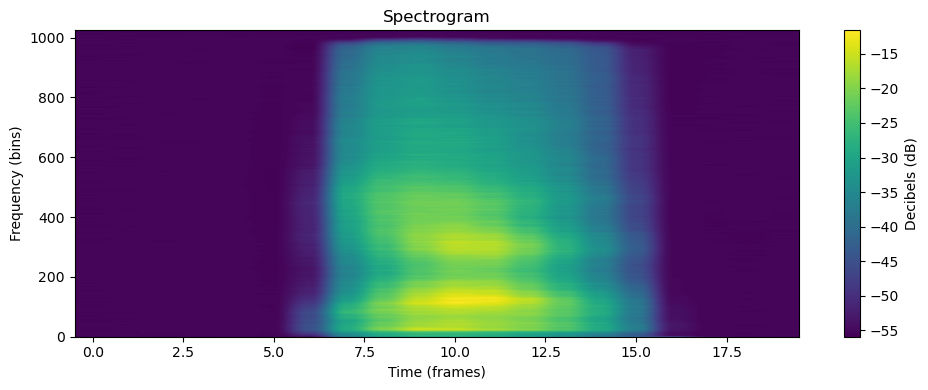

1/1 [==============================] - 0s 30ms/step
dog


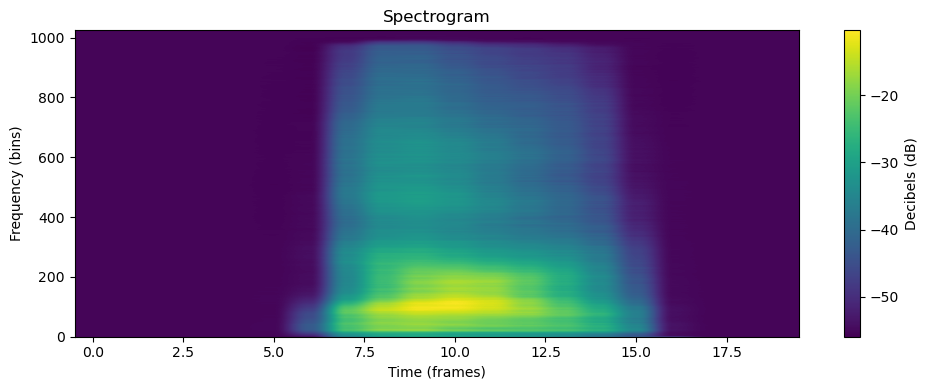

1/1 [==============================] - 0s 29ms/step
down


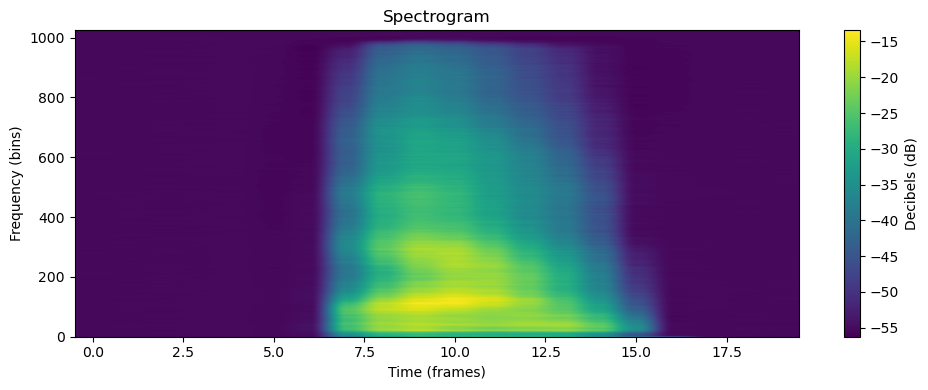

1/1 [==============================] - 0s 33ms/step
eight


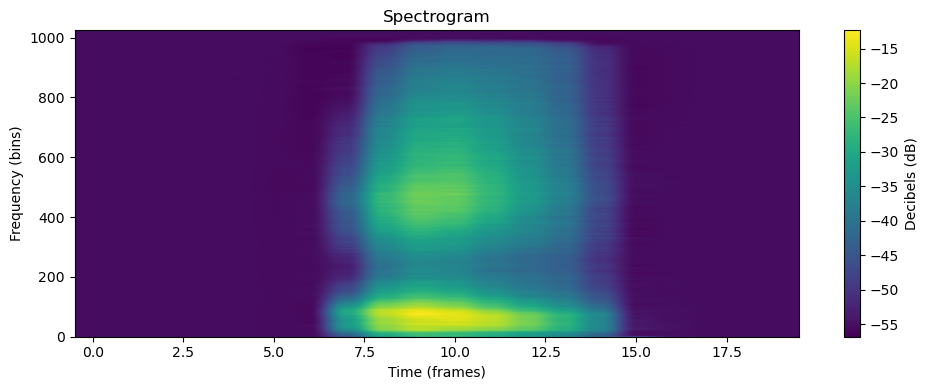

1/1 [==============================] - 0s 28ms/step
five


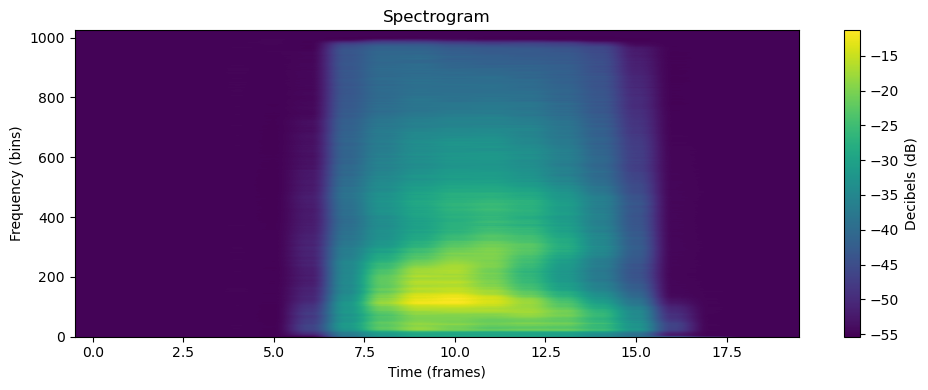

1/1 [==============================] - 0s 29ms/step
follow


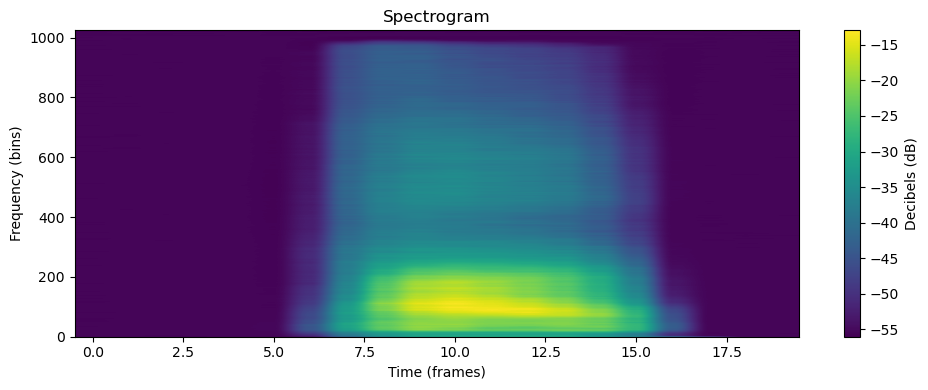

1/1 [==============================] - 0s 30ms/step
forward


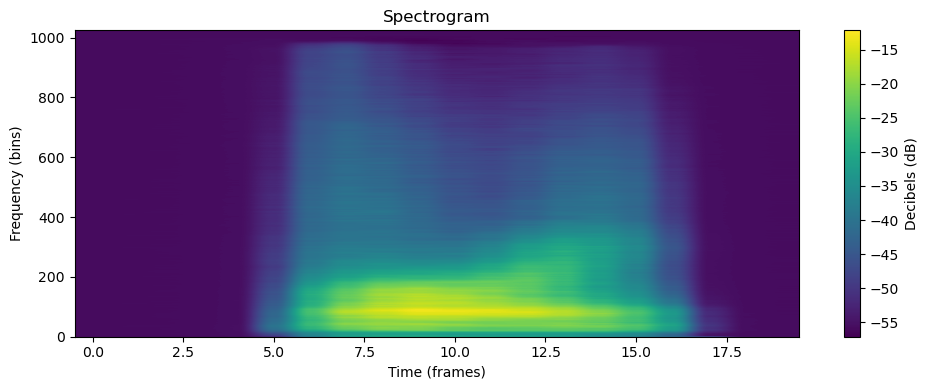

1/1 [==============================] - 0s 32ms/step
four


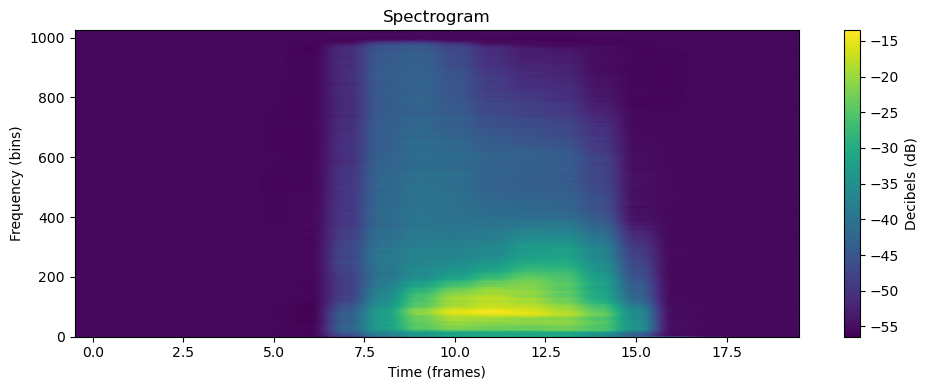

1/1 [==============================] - 0s 32ms/step
happy


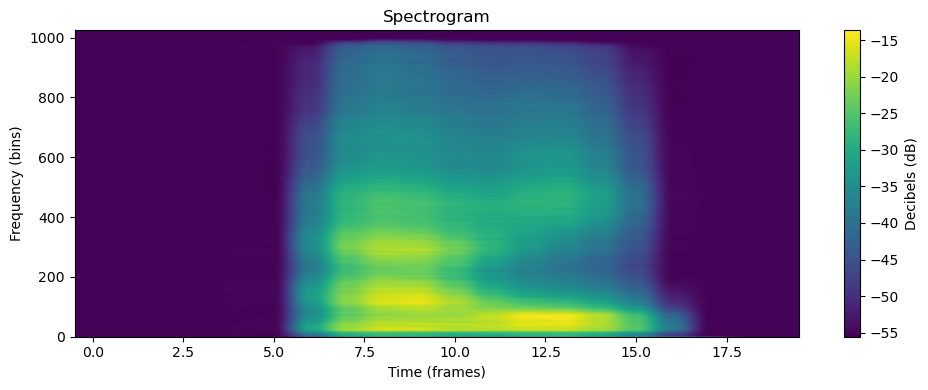

1/1 [==============================] - 0s 31ms/step
house


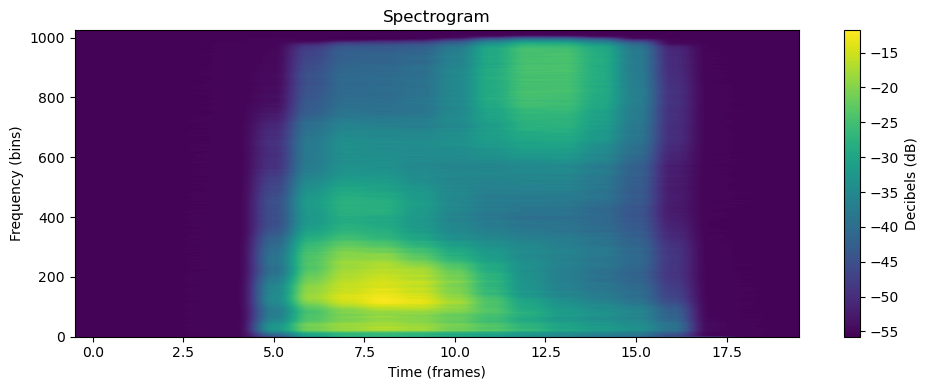

1/1 [==============================] - 0s 30ms/step
learn


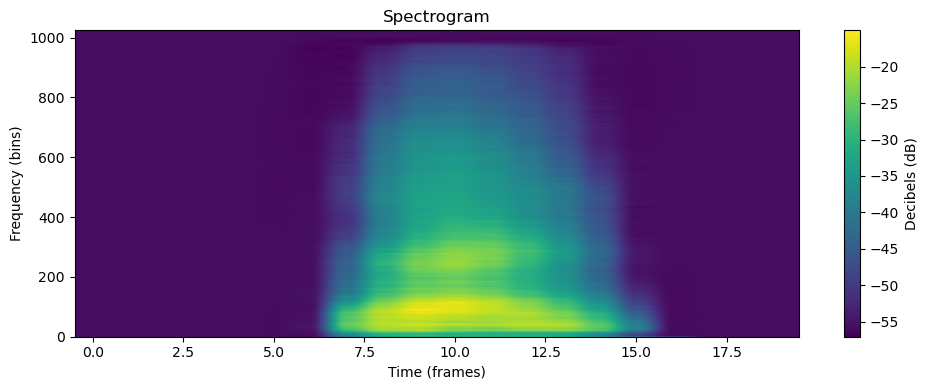

1/1 [==============================] - 0s 29ms/step
left


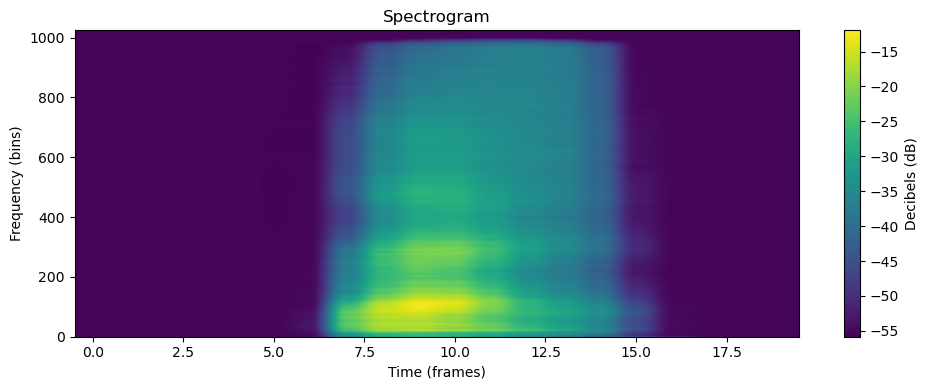

1/1 [==============================] - 0s 30ms/step
marvin


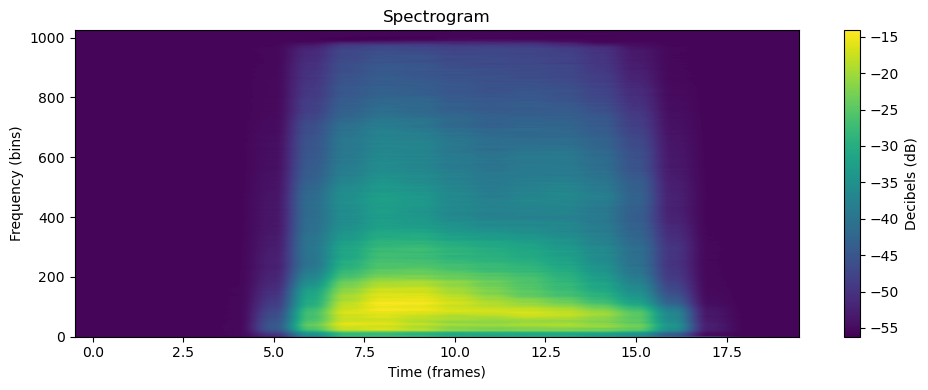

1/1 [==============================] - 0s 29ms/step
nine


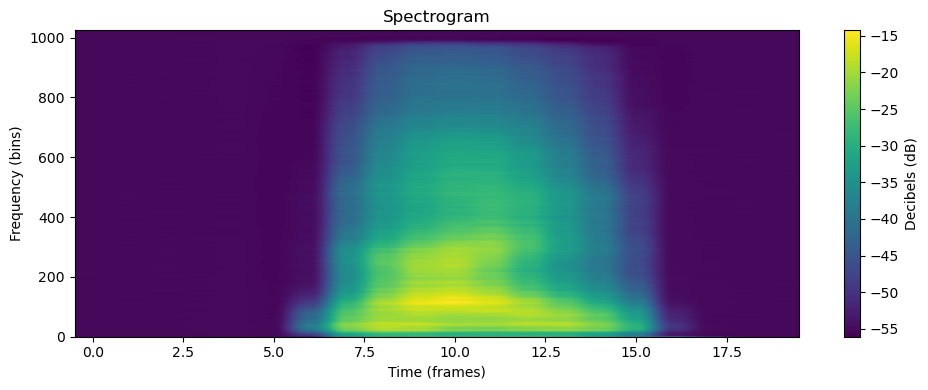

1/1 [==============================] - 0s 35ms/step
off


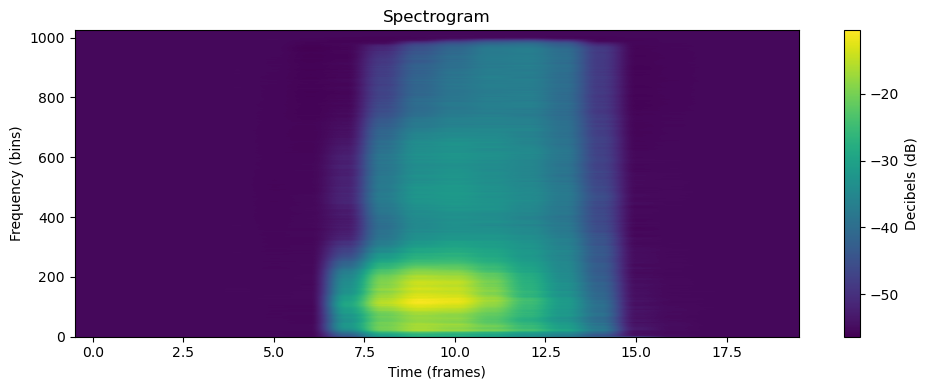

1/1 [==============================] - 0s 29ms/step
one


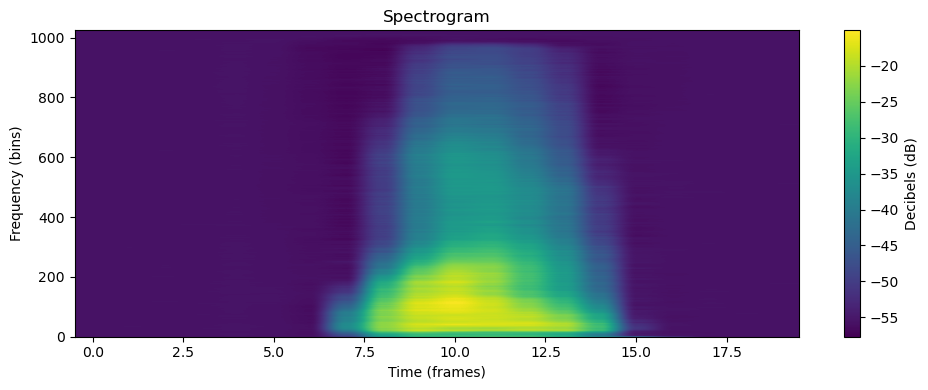

1/1 [==============================] - 0s 30ms/step
right


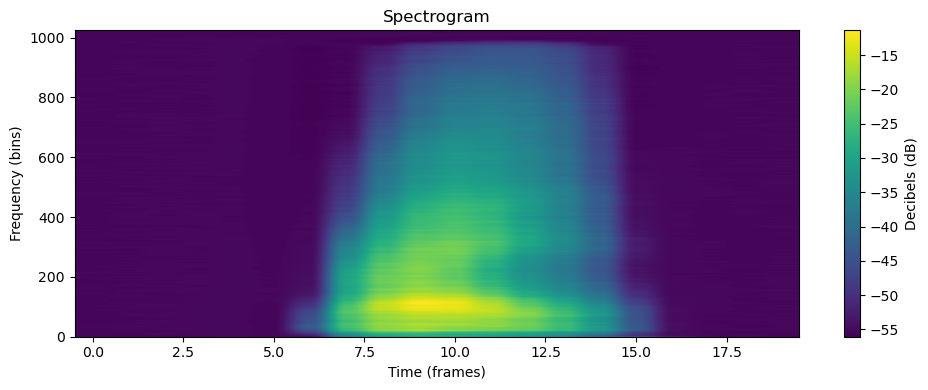

1/1 [==============================] - 0s 30ms/step
seven


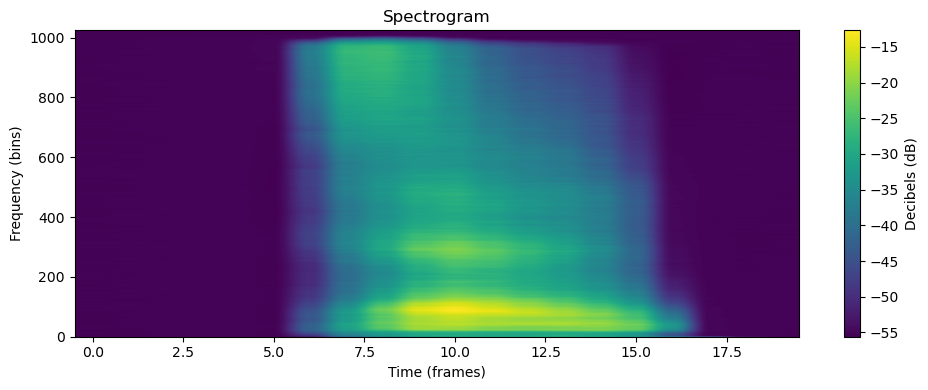

1/1 [==============================] - 0s 29ms/step
sheila


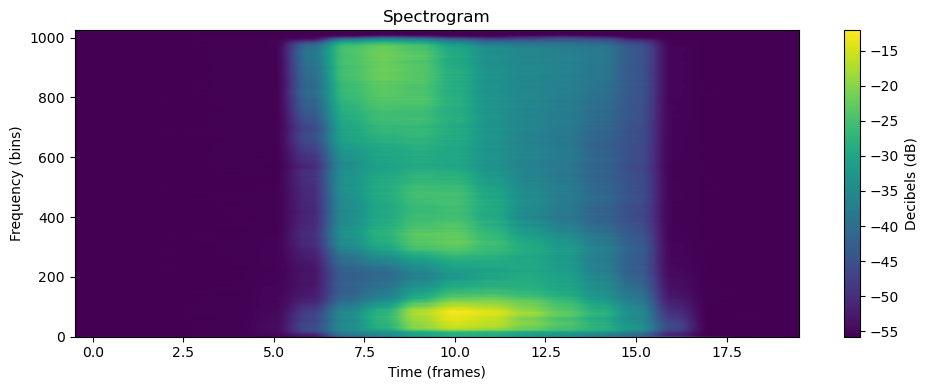

1/1 [==============================] - 0s 32ms/step
six


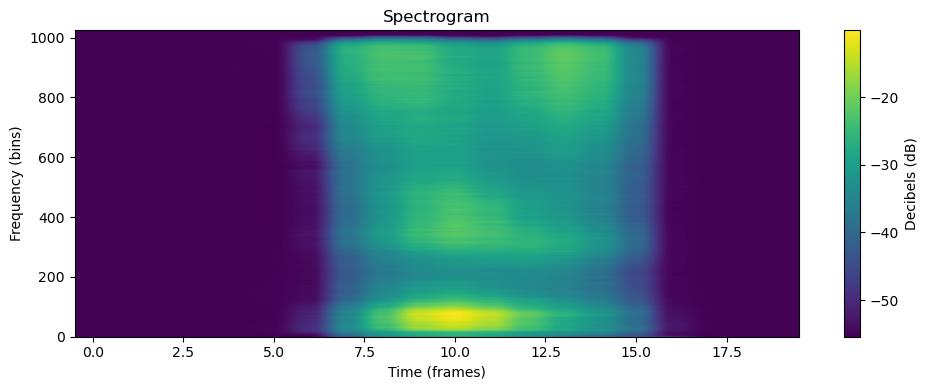

1/1 [==============================] - 0s 31ms/step
stop


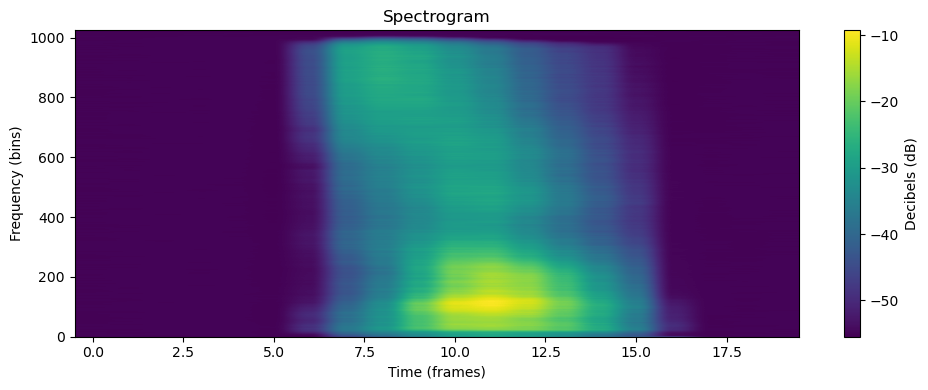

1/1 [==============================] - 0s 29ms/step
three


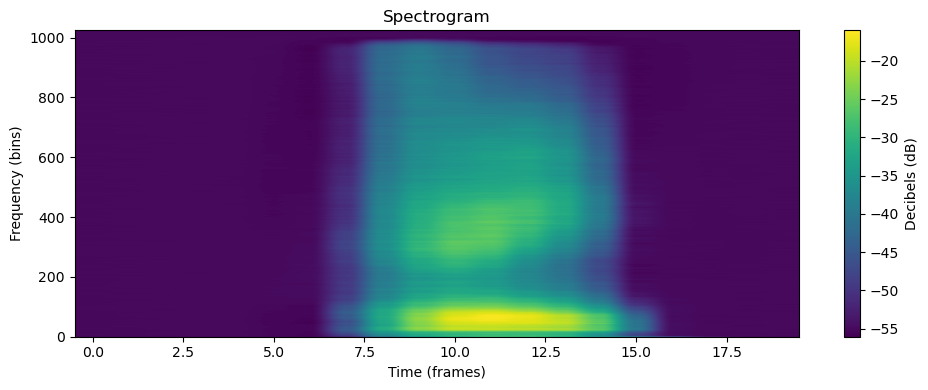

1/1 [==============================] - 0s 31ms/step
tree


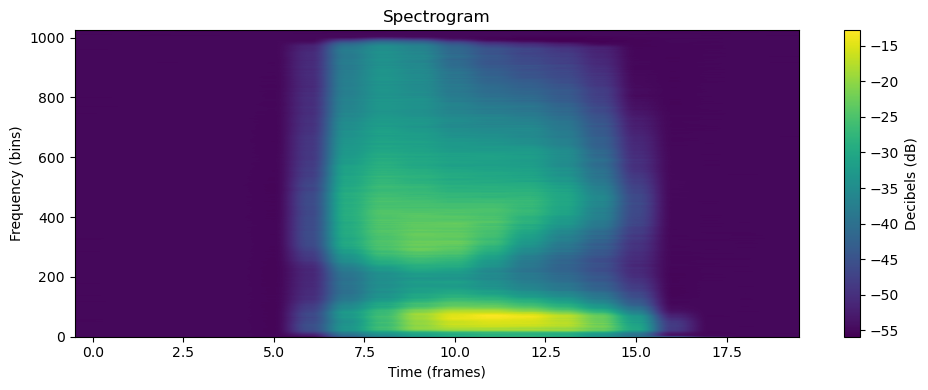

1/1 [==============================] - 0s 31ms/step
two


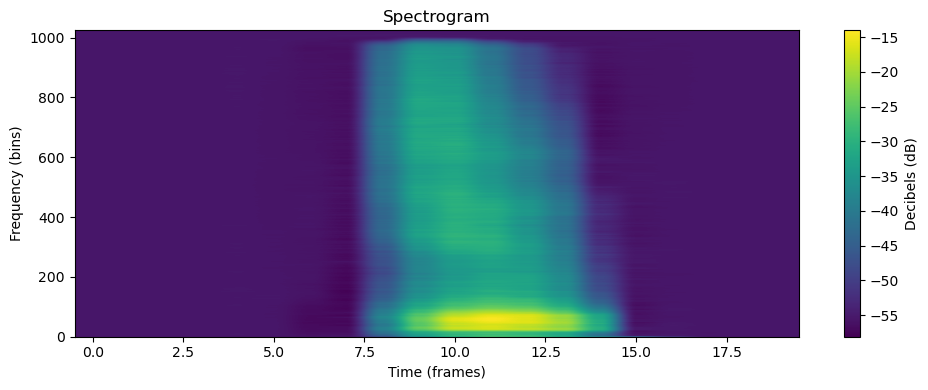

1/1 [==============================] - 0s 30ms/step
visual


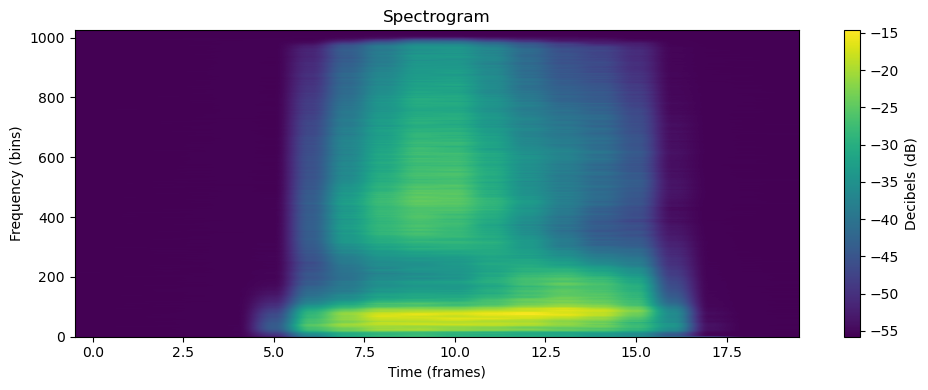

1/1 [==============================] - 0s 32ms/step
wow


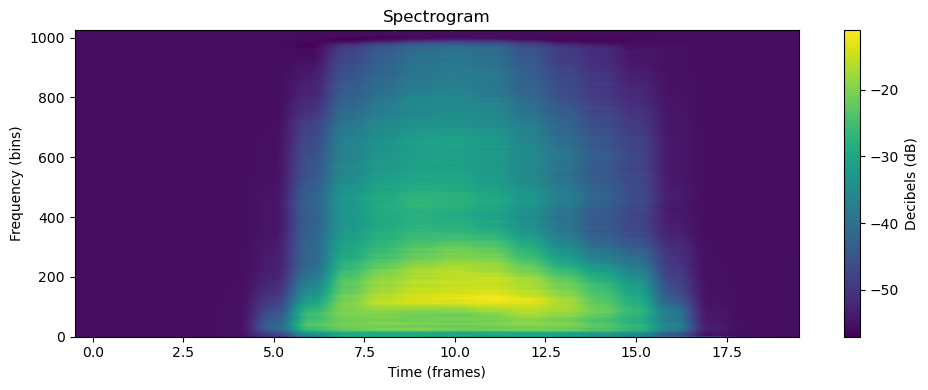

1/1 [==============================] - 0s 34ms/step
yes


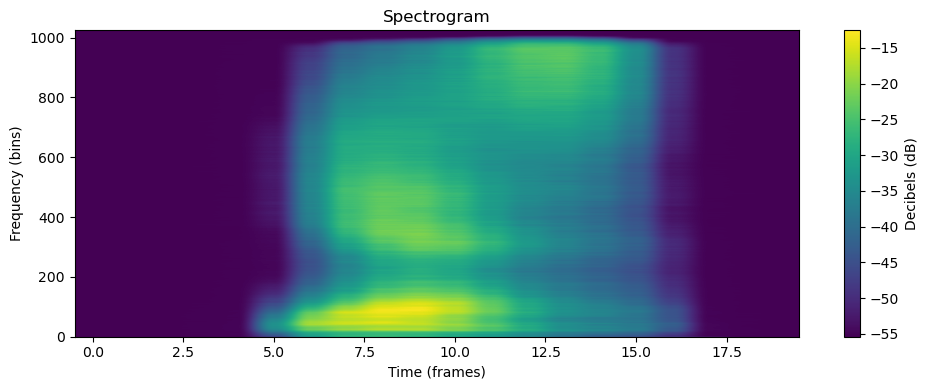

1/1 [==============================] - 0s 32ms/step
zero


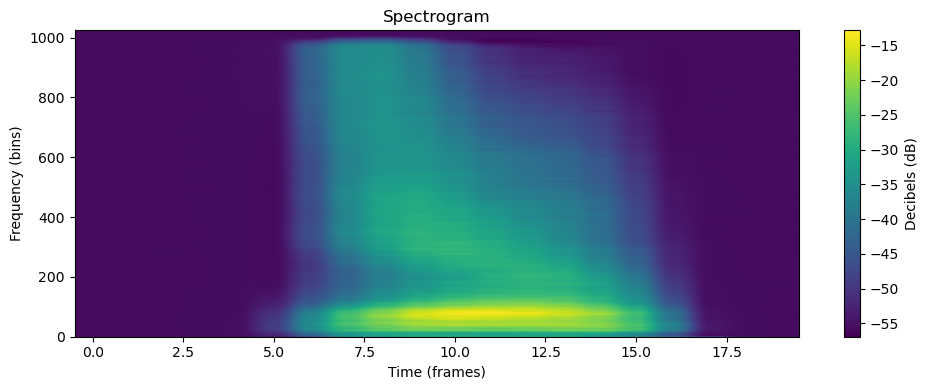

In [13]:
directory = "Audios"

if os.path.exists(directory):
    for element in os.listdir(directory):
        element_path = os.path.join(directory, element)
        os.unlink(element_path)
    os.rmdir(directory)

os.makedirs(directory)

for i in range(len(index_to_word)):
    prediction = model.predict([i])
    prediction = prediction[0]
    print(index_to_word[i])
    visualize_spectrogram(prediction)
    
    audio = spectrogram_to_audio_sin_fase(prediction, 11000)
    sf.write(directory + "//" + index_to_word[i] + ".wav", audio, samplerate = 11000, format = "wav")

In [15]:
#model.save_weights("model2.2.h5")